## Skorch RHC network classification example

In [1]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [2]:
import numpy as np
from sklearn.datasets import make_classification
import torch
from torch import nn
from skorch import NeuralNetClassifier
from skorch import NeuralNet
from pyperch.neural.rhc_nn import RHCModule  
from pyperch.utils.decorators import add_to
from skorch.dataset import unpack_data
import copy
import matplotlib.pyplot as plt

In [13]:
X, y = make_classification(1000, 12, n_informative=10, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)
print(X.shape, y.shape)
input_dim=12
output_dim=2
hidden_units=20
hidden_layers=1
step_size=.05

(1000, 12) (1000,)


In [14]:
rhc_module=RHCModule(input_dim=input_dim, output_dim=output_dim, hidden_units=hidden_units, hidden_layers=hidden_layers, step_size=step_size)

from skorch.callbacks import EpochScoring 

net = NeuralNetClassifier(
    rhc_module,
    max_epochs=5000,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

## train_step_single override - add RHC training step and disable backprop 

In [15]:
RHCModule.register_rhc_training_step()

In [16]:
# fit data
net.fit(X, y)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=RHCModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=12, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=20, bias=True)
      (2): Linear(in_features=20, out_features=2, bias=True)
    )
  ),
)

## Plot learning curves

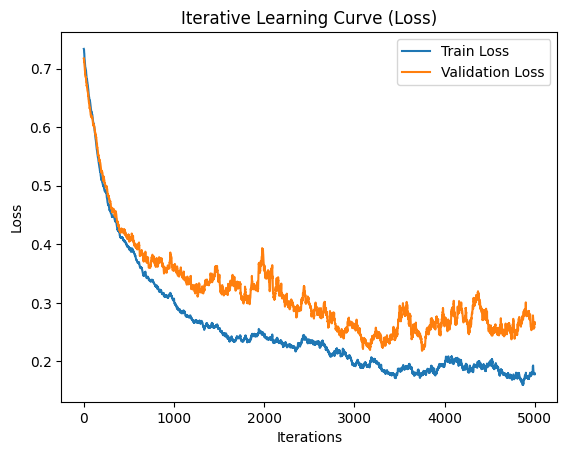

In [17]:
# plot the iterative learning curve (loss)
plt.plot(net.history[:, 'train_loss'], label='Train Loss')
plt.plot(net.history[:, 'valid_loss'], label='Validation Loss')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss)")
plt.legend()

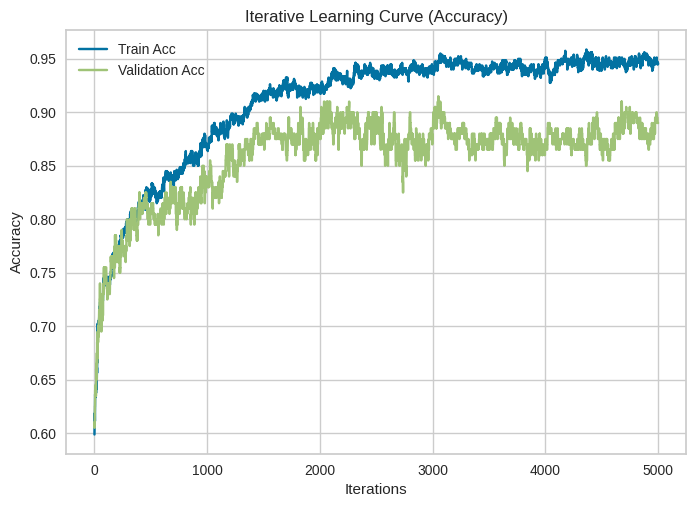

In [97]:
# plot the iterative learning curve (accuracy)
plt.plot(net.history[:, 'train_acc'], label='Train Acc')
plt.plot(net.history[:, 'valid_acc'], label='Validation Acc')
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Iterative Learning Curve (Accuracy)")
plt.legend()

## Using sklearn learning curve with RO

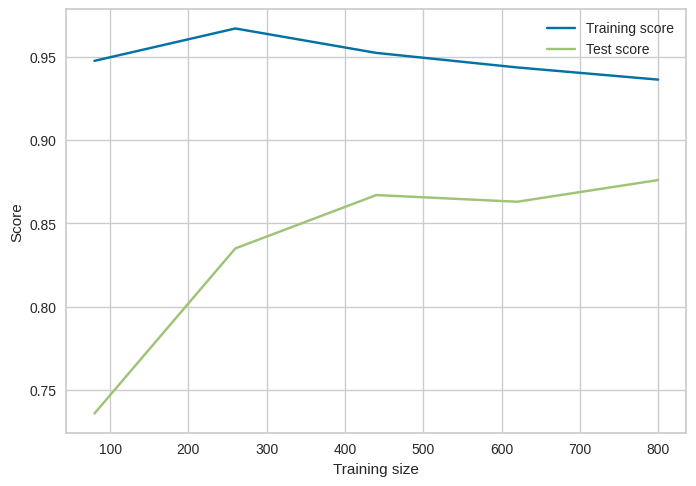

In [79]:
from sklearn.model_selection import learning_curve

# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    net, X, y, train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.plot(train_sizes, train_scores.mean(axis=1), label="Training score")
plt.plot(train_sizes, test_scores.mean(axis=1), label="Test score")
plt.xlabel("Training size")
plt.ylabel("Score")
plt.legend()

## Using sklearn pipeline with RO

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('net', net),
])

pipe.fit(X, y)
y_proba = pipe.predict_proba(X)

## Using sklearn grid search with RO

In [18]:
from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0, )

# module specific parameters need to begin with 'module__'
default_params = {
    'module__input_dim': [12],
    'module__output_dim': [2],
    'module__step_size': [0.1],
}

grid_search_params = {
    'max_epochs': [10, 20],
    'module__hidden_units': [10, 20],
    'module__hidden_layers': [1, 2],
    'module__activation': [nn.ReLU(), nn.Tanh()],
    **default_params,
}

gs = GridSearchCV(net, grid_search_params, refit=False, cv=3, scoring='accuracy', verbose=1)

gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END max_epochs=10, module__activation=ReLU(), module__hidden_layers=1, module__hidden_units=10, module__input_dim=12, module__output_dim=2, module__step_size=0.1; total time=   0.2s
[CV] END max_epochs=10, module__activation=ReLU(), module__hidden_layers=1, module__hidden_units=10, module__input_dim=12, module__output_dim=2, module__step_size=0.1; total time=   0.2s
[CV] END max_epochs=10, module__activation=ReLU(), module__hidden_layers=1, module__hidden_units=10, module__input_dim=12, module__output_dim=2, module__step_size=0.1; total time=   0.1s
[CV] END max_epochs=10, module__activation=ReLU(), module__hidden_layers=1, module__hidden_units=20, module__input_dim=12, module__output_dim=2, module__step_size=0.1; total time=   0.1s
[CV] END max_epochs=10, module__activation=ReLU(), module__hidden_layers=1, module__hidden_units=20, module__input_dim=12, module__output_dim=2, module__step_size=0.1; total time=   0.1s
[CV]